Distribuzione Poli-Consumatori (3+ droghe illegali): 
Poly_User
1    1407
0     478
Name: count, dtype: int64
Report Classificazione Poli-Consumatori:
              precision    recall  f1-score   support

           0       0.66      0.53      0.59       120
           1       0.85      0.91      0.88       352

    accuracy                           0.81       472
   macro avg       0.76      0.72      0.73       472
weighted avg       0.80      0.81      0.80       472



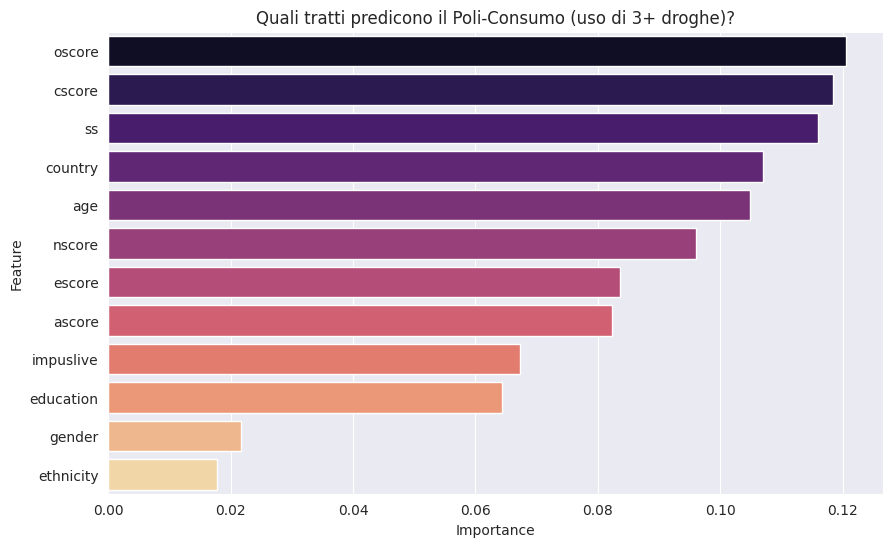

In [14]:
!pip install ucimlrepo -q

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from ucimlrepo import fetch_ucirepo

pd.set_option('future.no_silent_downcasting', True) # pulizia warning non necessario di pandas

# Convertiamo tutti i target in numerico binario (0=Non User, 1=User) per facilitare le analisi
drug_consumption = fetch_ucirepo(id=373)
X = drug_consumption.data.features
targets_numeric = drug_consumption.data.targets.copy()
targets_binary = targets_numeric.replace(
    {'CL0': 0, 'CL1': 0, 'CL2': 1, 'CL3': 1, 'CL4': 1, 'CL5': 1, 'CL6': 1}
)
# Creiamo liste di droghe legali vs illegali per i confronti
legal_drugs = ['alcohol', 'caffeine', 'chocolate', 'nicotine']
illegal_drugs = [col for col in targets_binary.columns if col not in legal_drugs and col != 'semer']

# Definiamo un "Poli-User" come qualcuno che usa 3 o più droghe illegali
targets_binary['Illegal_Sum'] = targets_binary[illegal_drugs].sum(axis=1)
targets_binary['Poly_User'] = (targets_binary['Illegal_Sum'] >= 3).astype(int)

y_poly = targets_binary['Poly_User']
print(f"Distribuzione Poli-Consumatori (3+ droghe illegali): \n{y_poly.value_counts()}")

# Addestriamo il modello su questo nuovo target
X_train, X_test, y_train, y_test = train_test_split(X, y_poly, test_size=0.25, stratify=y_poly, random_state=42)
rf_poly = RandomForestClassifier(n_estimators=100, random_state=42)
rf_poly.fit(X_train, y_train)
y_pred_poly = rf_poly.predict(X_test)

print("Report Classificazione Poli-Consumatori:")
print(classification_report(y_test, y_pred_poly))

# Feature Importance per Poli-consumo
importances_poly = pd.Series(rf_poly.feature_importances_, index=X.columns).sort_values(ascending=False)
df_imp = (
    importances_poly
    .reset_index()
    .rename(columns={"index": "Feature", 0: "Importance"})
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_imp,
    x="Importance",
    y="Feature",
    hue="Feature",     # required to allow palette
    palette="magma",
    legend=False
)

plt.title("Quali tratti predicono il Poli-Consumo (uso di 3+ droghe)?")
plt.show()